In [20]:
import ezdxf
import cv2
import numpy as np

def preprocess_dxf_file(dxf_name):
    dxf = ezdxf.readfile(dxf_name)
    msp = dxf.modelspace()
    mask = np.zeros((10000, 10000), dtype="uint8")
    # shift for centering
    c = 5000
    for l in msp:
        if l.dxftype() == "LINE":
            x1, y1 = list(map(round, l.dxf.start[0:2]))
            x2, y2 = list(map(round, l.dxf.end[0:2]))
            cv2.line(mask, (x1 + c, y1 + c), (x2 + c, y2 + c), 255, 1)
        if l.dxftype() == "CIRCLE":
            x1, y1 = list(map(round, l.dxf.center[0:2]))
            cv2.circle(mask, (x1 + c, y1 + c), round(l.dxf.radius), 255, thickness=1, lineType=8, shift=0)
        if l.dxftype() == "LWPOLYLINE":
            points = l.get_points("xyb")
            prev_point = points[0]
            for i in range(1, len(points)):
                point = points[i]
                if abs(prev_point[2]) == 1:
                    center_x = (round(prev_point[0]) + round(point[0])) // 2
                    center_y = (round(prev_point[1]) + round(point[1])) // 2
                    major_axe = abs(round(point[0]) - round(prev_point[0])) // 2
                    minor_axe = abs(round((round(point[0]) - round(prev_point[0]))) // 2)
                    cv2.ellipse(mask, (center_x + c, center_y + c), (major_axe, minor_axe), 0.0, 0.0, 360,
                                (255, 255, 255), 1)
                else:
                    x1, y1 = list(map(round, prev_point[0:2]))
                    x2, y2 = list(map(round, point[0:2]))
                    cv2.line(mask, (x1 + c, y1 + c), (x2 + c, y2 + c), 255, 1)
                prev_point = point
            if l.closed:
                x1, y1 = list(map(round, points[len(points) - 1][0:2]))
                x2, y2 = list(map(round, points[0][0:2]))
                cv2.line(mask, (x1 + c, y1 + c), (x2 + c, y2 + c), 255, 1)
        if l.dxftype() == "ARC":
            x1, y1 = list(map(round, l.dxf.center[0:2]))
            cv2.ellipse(mask, (x1 + c, y1 + c), (round(l.dxf.radius), round(l.dxf.radius)), 0, round(l.dxf.start_angle),
                        round(l.dxf.end_angle), 255, thickness=1, lineType=8, shift=0)
    # returning an image
    return mask


def get_min(cont):
    minX = np.min(cont[:, 0, 0])
    minY = np.min(cont[:, 0, 1])
    return minX, minY


def get_outer_rect(image):
    return get_outer_contour_with_info(image)[1]


def get_outer_contour(image):
    return get_outer_contour_with_info(image)[2]


def get_outer_contour_with_info(thresh_img):
    contours, _ = cv2.findContours(thresh_img, cv2.RETR_LIST, cv2.CHAIN_APPROX_NONE)
    # find the outer contour
    get_area = lambda c: -c[2] * c[3]
    contour_sizes = [(get_area(cv2.boundingRect(contour)), cv2.boundingRect(contour), contour) for contour in contours]
    biggest_contour = sorted(contour_sizes, key=lambda x: x[0])[0]
    return biggest_contour


def extract_info(dxf_name):
    thresh_img = preprocess_dxf_file(dxf_name)
    x1, y1, w, h = get_outer_rect(thresh_img)
    # normalize coordinates
    contour = get_outer_contour(thresh_img)
    minX, minY = get_min(contour)
    cnt_norm = contour - [minX, minY]
    return cnt_norm, (w, h)


def get_contour_from_dxf(dxf_name):
    """
    Main method that extracts contour from dxf as a np.ndarray
    @param dxf_name: path to dxf file
    @return: contour np.ndarray
    """
    contour = extract_info(dxf_name)[0]
    contour = contour.squeeze()
    return contour


def get_size_from_dxf(dxf_name):
    return extract_info(dxf_name)[1]


In [26]:
import numpy as np

def points_sequence_to_lines(contour):
    """
    Reduces chains of 3+ sequential points with diff only in one
    coordinate down to 2 points
    @param contour: dxf contour
    @return: contour: compressed dxf contour
    """
    assert isinstance(contour, np.ndarray)
    assert len(contour.shape) == 2
    assert contour.shape[1] == 2

    def is_line(c1, c2):
        if abs(c1[0] - c2[0]) >= 1 and abs(c1[1] - c2[1]) == 0:
            return True
        if abs(c1[1] - c2[1]) >= 1 and abs(c1[0] - c2[0]) == 0:
            return True
        return False

    contour = contour.squeeze().tolist()
    new_contour = []
    prev_coord = contour[0]
    for i, coord in enumerate(contour[1:], start=1):
        # if current point breaks straight line, call it a node
        # and append to polyline contour. Try to examine next line
        # from this breakpoint
        if not is_line(prev_coord, contour[i]):
            new_contour.append(contour[i])
            prev_coord = contour[i]

    new_contour = np.array(new_contour)
    return new_contour


def filter_points_duplicates(contour):
    """
    Deletes sequential duplicating points from contour
    @param contour: dxf contour
    @return: contour: compressed dxf contour
    """
    assert isinstance(contour, np.ndarray)
    assert len(contour.shape) == 2
    assert contour.shape[1] == 2

    def is_duplicate(c1, c2):
        return c1 == c2

    contour = contour.squeeze().tolist()
    new_contour = []
    prev_coord = contour[0]
    for i, coord in enumerate(contour[1:], start=1):

        if not is_duplicate(prev_coord, contour[i]):
            new_contour.append(contour[i])
            prev_coord = contour[i]

    new_contour = np.array(new_contour)
    return new_contour

In [48]:
def move_to_00(contour):
    """
    Translates upper-left contour point (and all its point)
    to the origin of coordinate plane
    @param contour: dxf contour
    @return: contour: translated dxf contour
    """
    assert isinstance(contour, np.ndarray)
    assert len(contour.shape) == 2
    assert contour.shape[1] == 2

    minx, miny = min(contour[:, 0]), min(contour[:, 1])
    contour -= np.array([minx, miny])
    return contour

def get_contour_size(contour):
    maxx, maxy = max(contour[:, 0]), max(contour[:, 1])
    return maxx, maxy

In [161]:
path = '/data/detail_price/dxf_хпц/dxf_ХПЦ_ТВЗ/'
name = '4498.25.15.312.dxf'

In [162]:
contour = get_contour_from_dxf(path + name)
contour.shape

(414, 2)

In [163]:
contour = points_sequence_to_lines(contour)
contour.shape

(22, 2)

In [164]:
contour = filter_points_duplicates(contour)
contour.shape

(21, 2)

In [165]:
contour = move_to_00(contour)
get_contour_size(contour)

(185, 23)

In [ ]:
[(1.0, 0.0), 
 (185.0, 1.0), 
 (184.0, 24.0), 
 (180.0, 23.0), 
 (170.0, 22.0), 
 (160.0, 21.0), 
 (151.0, 20.0), 
 (141.0, 19.0), 
 (131.0, 18.0), 
 (122.0, 17.0), 
 (112.0, 16.0), 
 (102.0, 15.0), 
 (82.0, 16.0), 
 (72.0, 17.0), 
 (62.0, 18.0), 
 (53.0, 19.0), 
 (43.0, 20.0), 
 (33.0, 21.0), 
 (24.0, 22.0), 
 (14.0, 23.0), 
 (4.0, 24.0), 
 (0.0, 23.0)]


In [166]:
contour

array([[185,   0],
       [184,  23],
       [180,  22],
       [170,  21],
       [160,  20],
       [151,  19],
       [141,  18],
       [131,  17],
       [122,  16],
       [112,  15],
       [102,  14],
       [ 82,  15],
       [ 72,  16],
       [ 62,  17],
       [ 53,  18],
       [ 43,  19],
       [ 33,  20],
       [ 24,  21],
       [ 14,  22],
       [  4,  23],
       [  0,  22]])

In [167]:
from PIL import Image, ImageDraw
from shapely import geometry, affinity

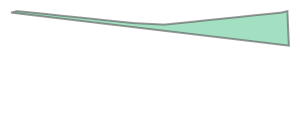

In [168]:
k = 3
poly = geometry.Polygon(contour)
affinity.scale(poly, k, k)

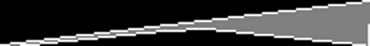

In [169]:
size = get_contour_size(contour)
k = 2

img = Image.new('L', size)
im = ImageDraw.Draw(img)
im.polygon(list(map(lambda p: (int(p[0]), int(p[1])), contour)), 
                        fill=128, outline=255)
img.resize((size[0]*k, size[1]*k))

In [86]:
size

(115, 74)